In [1]:
import os
import json
import random
import argparse
import cv2 as cv
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
import detectron2.model_zoo as model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [2]:
parser = argparse.ArgumentParser(description="Pothole Segmentation")
parser.add_argument("--path", type=str, default=os.path.join(os.getcwd(), "data"), help="Path to the data directory")
parser.add_argument("--target", type=str, default="images", help="Target directory (images, videos)", choices=["images", "videos"])
args, unknown = parser.parse_known_args()


path = args.path
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

trainPath = os.path.join(path, args.target, "train")
valPath = os.path.join(path, args.target, "val")

if not os.path.exists(trainPath):
    raise ValueError(f"Path {trainPath} does not exist")
if not os.path.exists(valPath):
    raise ValueError(f"Path {valPath} does not exist")

trainCocoPath = os.path.join(trainPath, "cocoLabels.json")
valCocoPath = os.path.join(valPath, "cocoLabels.json")

---

## Registra Dataset in COCO Format

In [3]:
register_coco_instances("pothole_train", {}, trainCocoPath, os.path.join(trainPath, "images"))
register_coco_instances("pothole_val", {}, valCocoPath, os.path.join(valPath, "images"))

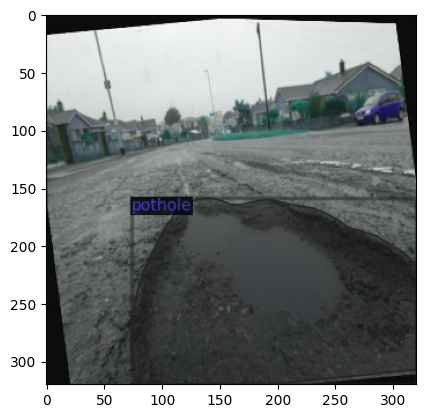

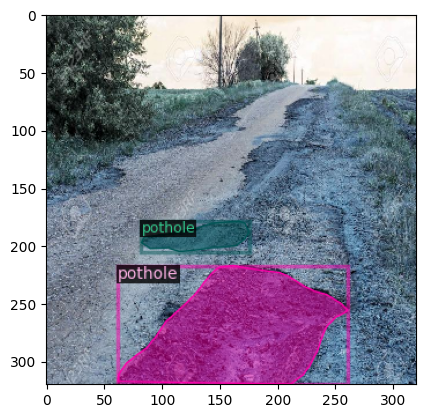

In [4]:
train = DatasetCatalog.get("pothole_train")
val = DatasetCatalog.get("pothole_val")

for elem in random.sample(train, 1):
    img = cv.imread(elem["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("pothole_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(elem)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()
for elem in random.sample(val, 1):
    img = cv.imread(elem["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("pothole_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(elem)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

----

## Define Model

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pothole_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025    #! Incrementa probabilmente
cfg.SOLVER.MAX_ITER = 2000       #! Incrementa probabilmente
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #! Incrementa probabilmente a 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Solo una classe (pothole)

--- 

## Train

In [6]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/21 16:47:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/21 16:47:59 d2.engine.train_loop]: Starting training from iteration 0


/home/cati/.local/share/virtualenvs/PotholeSegmentation-k4bOT_HL/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/21 16:48:05 d2.utils.events]:  eta: 0:07:45  iter: 19  total_loss: 1.522  loss_cls: 0.6045  loss_box_reg: 0.08223  loss_mask: 0.6908  loss_rpn_cls: 0.09909  loss_rpn_loc: 0.01008    time: 0.2490  last_time: 0.2038  data_time: 0.0070  last_data_time: 0.0024   lr: 4.9953e-06  max_mem: 2415M
[02/21 16:48:10 d2.utils.events]:  eta: 0:07:43  iter: 39  total_loss: 1.481  loss_cls: 0.5444  loss_box_reg: 0.1363  loss_mask: 0.6839  loss_rpn_cls: 0.1052  loss_rpn_loc: 0.01504    time: 0.2418  last_time: 0.2409  data_time: 0.0026  last_data_time: 0.0024   lr: 9.9902e-06  max_mem: 2417M
[02/21 16:48:15 d2.utils.events]:  eta: 0:07:34  iter: 59  total_loss: 1.337  loss_cls: 0.4247  loss_box_reg: 0.1379  loss_mask: 0.6773  loss_rpn_cls: 0.05961  loss_rpn_loc: 0.01083    time: 0.2365  last_time: 0.2128  data_time: 0.0026  last_data_time: 0.0027   lr: 1.4985e-05  max_mem: 2417M
[02/21 16:48:19 d2.utils.events]:  eta: 0:07:27  iter: 79  total_loss: 1.253  loss_cls: 0.3179  loss_box_reg: 0.1316  los

----

## Show Results

Best iteration: 1959
Best accuracy: 0.9353406266352695
Best loss: 0.151859350502491


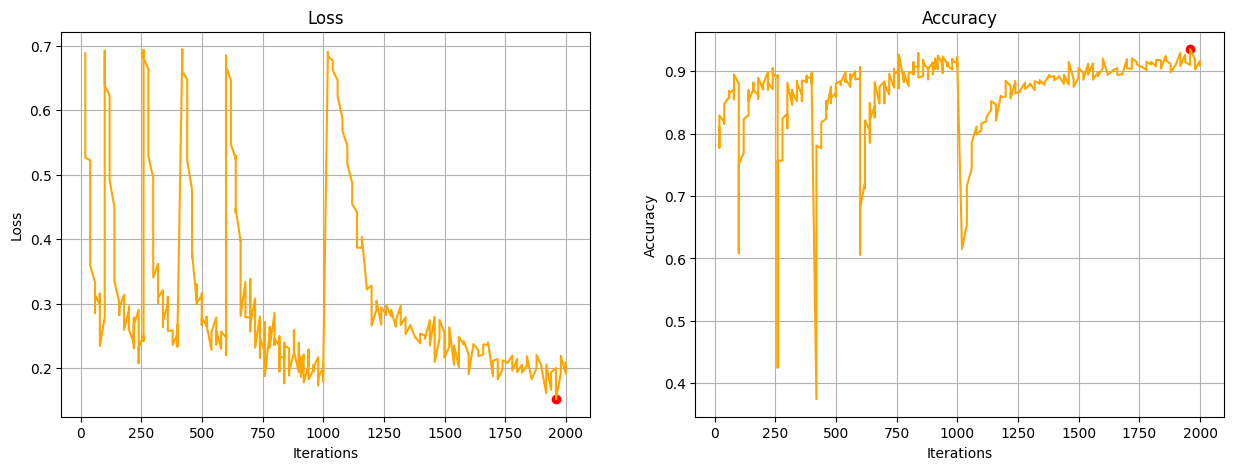

In [7]:
resultsPath = os.path.join(cfg.OUTPUT_DIR, "metrics.json")

results = []
with open(resultsPath, "r") as f:
    lines = f.readlines()
    for line in lines:
        results.append(json.loads(line))


# iteration, loss_mask, mask_rccn/accuracy
accuracy = []
loss_mask = []
iterations = sorted([elem["iteration"] for elem in results])

for i in range(len(results)):
    if "loss_mask" in results[i] and "mask_rcnn/accuracy" in results[i]:
        loss_mask.append(results[i]["loss_mask"])
        accuracy.append(results[i]["mask_rcnn/accuracy"])
    else:
        iterations.pop(i)

print(f"Best iteration: {iterations[accuracy.index(max(accuracy))]}")
print(f"Best accuracy: {max(accuracy)}")
print(f"Best loss: {loss_mask[accuracy.index(max(accuracy))]}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(iterations, loss_mask, color="orange")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid()
plt.scatter(iterations[accuracy.index(max(accuracy))], loss_mask[accuracy.index(max(accuracy))], color="red")

plt.subplot(1, 2, 2)
plt.plot(iterations, accuracy, color="orange")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.scatter(iterations[accuracy.index(max(accuracy))], max(accuracy), color="red")

plt.show()

---

## Predict

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 #! search for better value
predictor = DefaultPredictor(cfg)

[02/21 17:02:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


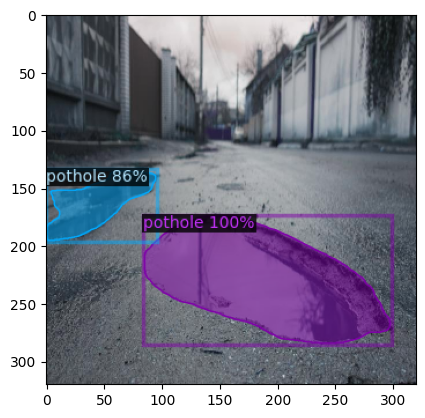

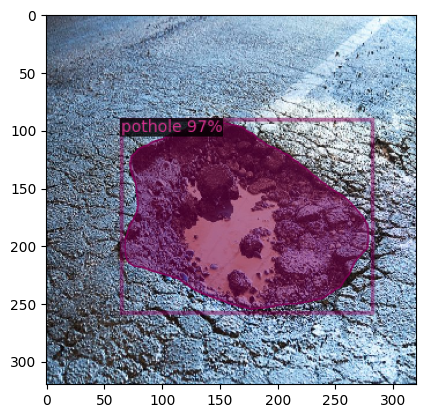

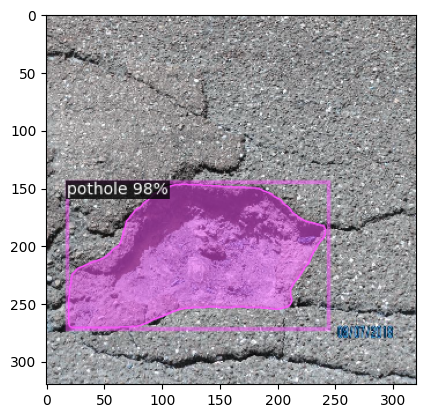

In [13]:
for elem in random.sample(val, 3):    
    im = cv.imread(elem["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("pothole_val"), scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

----

## Evaluate

In [14]:
metrics = {"train": None, "val": None}

for split in ["train", "val"]:
    evaluator = COCOEvaluator(f"pothole_{split}", output_dir="./output/")
    loader = build_detection_test_loader(cfg, f"pothole_{split}")
    metrics[split] = inference_on_dataset(predictor.model, loader, evaluator)

[02/21 17:02:33 d2.data.datasets.coco]: Loaded 720 images in COCO format from /home/cati/Scrivania/Dev/PotholeSegmentation/data/images/train/cocoLabels.json
[02/21 17:02:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/21 17:02:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/21 17:02:33 d2.data.common]: Serializing 720 elements to byte tensors and concatenating them all ...
[02/21 17:02:33 d2.data.common]: Serialized dataset takes 1.00 MiB
[02/21 17:02:33 d2.evaluation.evaluator]: Start inference on 720 batches
[02/21 17:02:33 d2.evaluation.evaluator]: Inference done 11/720. Dataloading: 0.0006 s/iter. Inference: 0.0472 s/iter. Eval: 0.0037 s/iter. Total: 0.0516 s/iter. ETA=0:00:36
[02/21 17:02:38 d2.evaluation.evaluator]: Inference done 113/720. Dataloading: 0.0008 s/iter. Inference: 0.0467 s/iter. Eval: 0

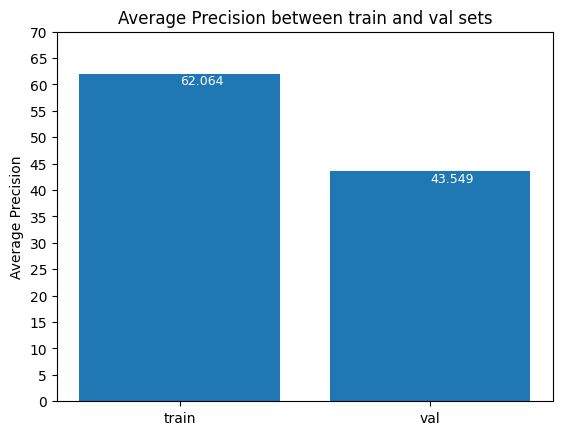

In [11]:
plt.bar(["train", "val"], [metrics["train"]["bbox"]["AP"], metrics["val"]["bbox"]["AP"]])
plt.ylabel("Average Precision")
plt.title("Average Precision between train and val sets")
plt.ylim(0, max([metrics["train"]["bbox"]["AP"], metrics["val"]["bbox"]["AP"]]) + 5)
plt.yticks([i for i in range(0, int(max([metrics["train"]["bbox"]["AP"], metrics["val"]["bbox"]["AP"]]) + 10), 5)])
plt.text(0, metrics["train"]["bbox"]["AP"] - 2, f"{metrics['train']['bbox']['AP']:0.3f}", fontsize=9, color="white")
plt.text(1, metrics["val"]["bbox"]["AP"] - 2, f"{metrics['val']['bbox']['AP']:0.3f}", fontsize=9, color="white")
plt.show()